In [7]:
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

## VIA(VGG Image Annotator) to YOLOv7 format

In [8]:
def VIA2YOLOv7_seg(annotations_path, savefolder, imagepath):
    annotations = json.load(open(annotations_path))

    annotations = list(annotations.values()) 
    annotations = [a for a in annotations if a['regions']]

    for a in annotations:
        polygons=[]
        if type(a['regions']) is dict:
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
        else:
            polygons = [r['shape_attributes'] for r in a['regions']] 

        rects = [r['shape_attributes'] for r in a['regions']]
        name = [s['region_attributes']for s in a['regions']]

        sumn=0
        delpolygon=[]
        num_ids=[]
        for n in name:
            try:
                
                if n['name']=='handhole':
                    num_ids.append(0)
                else: ## manhole
                    num_ids.append(1)

            except:
                pass
            sumn+=1
            
        polygons=np.delete(polygons,delpolygon)

        idSUM=0
        if (num_ids!=[]):
            #f.write("dataset\\" + str(a['filename']) )
            for g in polygons:
                f = open(os.path.join(savefolder, str(a['filename'][:-4])+ ".txt"), "a")
                images = os.path.join(imagepath, a['filename'])
                image = cv2.imread(images)
                imgH, imgW, _ = image.shape
                norX = [x/imgW for x in g['all_points_x']]
                norY = [x/imgH for x in g['all_points_y']]
                newlist = [e for t in zip(norX, norY) for e in t]
                #print(newlist)
                try:
                    f.write(str([num_ids][0][idSUM])+ ' ' + str(newlist)[1:-1].replace(',', '') )
                    f.close()
                except:
                    pass

                idSUM+=1

## Visualization

In [9]:
def read_image_label(path_to_img: str, path_to_txt: str, normilize: bool = False):
    
    # read image
    image = cv2.imread(path_to_img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w = image.shape[:2]
  
    # read .txt file for this image
    with open(path_to_txt, "r") as f:
        txt_file = f.readlines()[0].split()
        cls_idx = txt_file[0]
        coords = txt_file[1:]
        polygon = np.array([[eval(x), eval(y)] for x, y in zip(coords[0::2], coords[1::2])]) # convert list of coordinates to numpy massive
  
    # Convert normilized coordinates of polygons to coordinates of image
    if normilize:
        polygon[:,0] = polygon[:,0]*img_w
        polygon[:,1] = polygon[:,1]*img_h
    return image, polygon.astype(np.int_)


def show_image_mask(img: np.array, polygon: np.array, alpha: float = 0.7):
    
    # Create zero array for mask
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    overlay = img.copy()
    
    # Draw polygon on the image and mask
    cv2.fillPoly(mask, pts=[polygon], color=(255, 255, 255))
    cv2.fillPoly(img, pts=[polygon], color=(255, 0, 0))
    cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)
    
    # Plot image with mask
    fig = plt.figure(figsize=(22,18))
    axes = fig.subplots(nrows=1, ncols=2)
    axes[0].imshow(img)
    axes[1].imshow(mask, cmap="Greys_r")
    axes[0].set_title("Original image with mask")
    axes[1].set_title("Mask")
    
    plt.show()

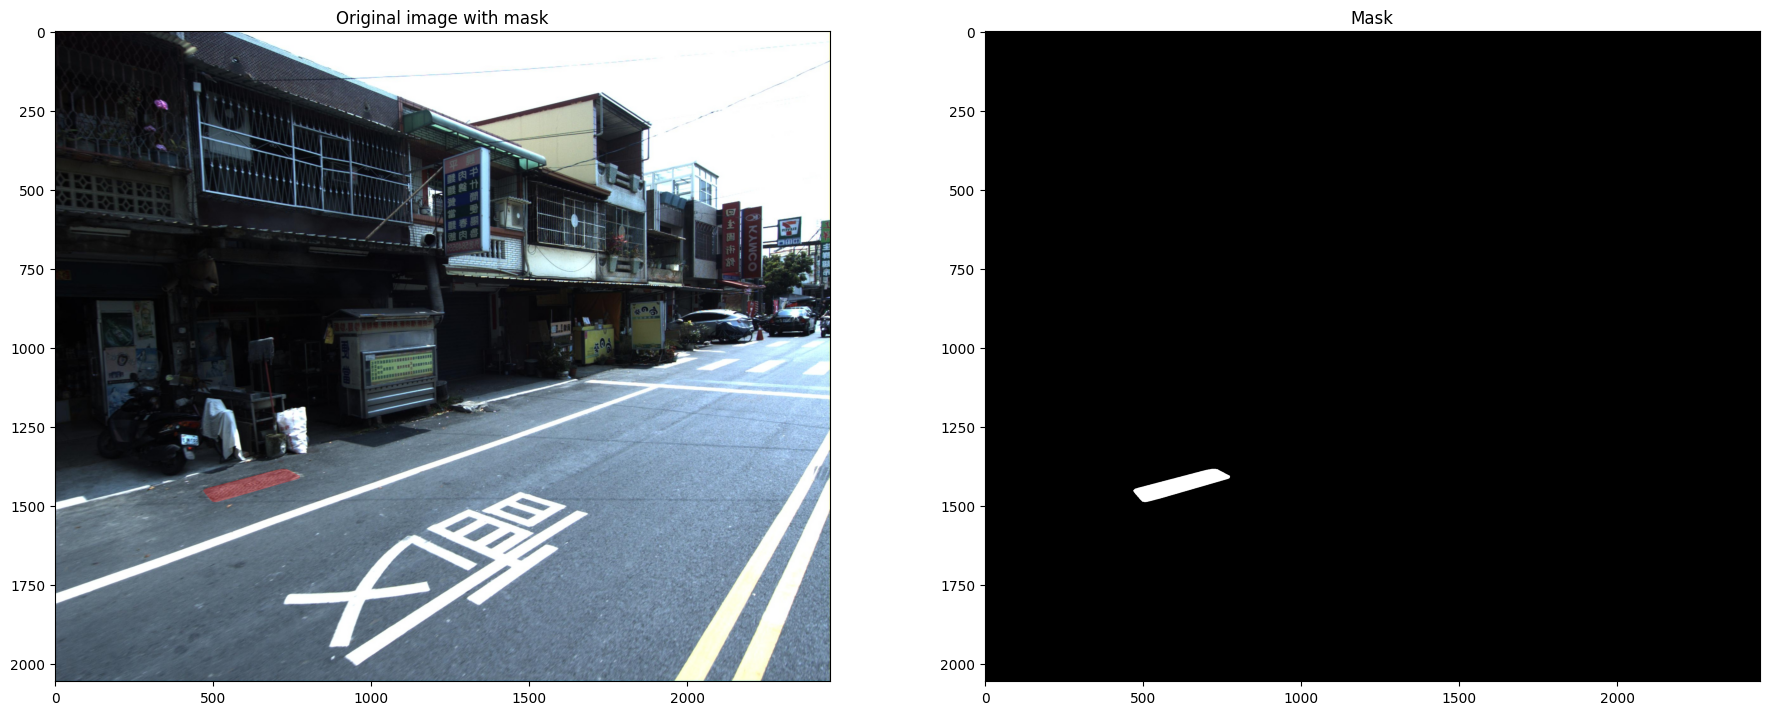

In [10]:
if __name__=='__main__':
    annotations_path = "D:/final_hole/images/val/via_region_data.json"
    savefolder = 'D:/final_hole/labels/val/'
    imagepath = "D:/final_hole/images/val/"
    VIA2YOLOv7_seg(annotations_path, savefolder, imagepath)
    path_to_img = 'D:/170418_020835855_Camera_1.jpg'
    path_to_txt = 'D:/170418_020835855_Camera_1.jpg.txt'
    image, polygon= read_image_label(path_to_img, path_to_txt)
    show_image_mask(image, polygon)